In [1]:
import numpy as np
from jax import numpy as jnp, random
from modax.models import Deepmod
from modax.training.utils import create_update
from flax import optim
from modax.training import train_max_iter
from modax.training.losses.SBL import loss_fn_SBL
from modax.training.losses import loss_fn_mse

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

In [2]:
key = random.PRNGKey(42)

# Prepping data

In [3]:
u = np.load('KS_u.npy')
x = np.load('KS_x.npy')
t = np.load('KS_t.npy')

In [4]:
u.shape

(1024, 251)

In [5]:
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')

<AxesSubplot:>

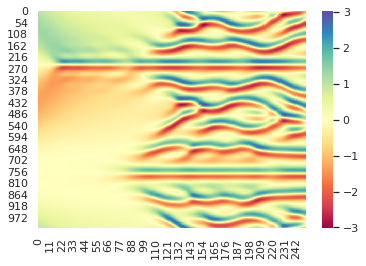

In [6]:
sns.heatmap(u, cmap='Spectral')

In [7]:
noise = 0.20
u_noisy = u + noise * np.std(u) * np.random.randn(*u.shape)
mask = np.logical_and(t > 45, t < 55)


In [8]:
y = jnp.array(u_noisy[::4, mask].reshape(-1, 1))
X = jnp.array(np.concatenate([t_grid[::4, mask].reshape(-1, 1), x_grid[::4, mask].reshape(-1, 1)], axis=1))

print(y.shape)

(6400, 1)


In [9]:
(np.std(u) * 0.20)**2

0.04555866448242895

In [10]:
(np.std(u) * 0.05)

0.05336118936223039

# Preconditioning model

It could help if we precondition the model a ltitle bit by training just mse.

In [11]:
max_iterations = 10000

In [12]:
model = Deepmod([60, 60, 60, 60, 60, 1], (5, 4))
optimizer_def = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
update_fn = create_update(loss_fn_mse, (model, X, y))
variables = model.init(key, X)
state, params = variables.pop("params")
optimizer = optimizer_def.create(params)

In [13]:
optimizer = train_max_iter(
        update_fn,
        optimizer,
        state,
        max_iterations)[0]

Loss step 0: 1.7643957138061523
Loss step 500: 1.2809253931045532
Loss step 1000: 1.1283061504364014
Loss step 1500: 0.9650622606277466
Loss step 2000: 0.8136864900588989
Loss step 2500: 0.7165152430534363
Loss step 3000: 0.6629937887191772
Loss step 3500: 0.6115981936454773
Loss step 4000: 0.5693185925483704
Loss step 4500: 0.5286850333213806
Loss step 5000: 0.5066194534301758
Loss step 5500: 0.4814065396785736
Loss step 6000: 0.4389858841896057
Loss step 6500: 0.3863404095172882
Loss step 7000: 0.3257733881473541
Loss step 7500: 0.2898959219455719
Loss step 8000: 0.2387595921754837
Loss step 8500: 0.22545772790908813
Loss step 9000: 0.22502444684505463
Loss step 9500: 0.19992420077323914


# Running model

In [16]:
max_iterations = 200000

In [17]:
update_fn = create_update(loss_fn_SBL, (model, X, y, True))
phase_2_state = (state, {"prior_init": None})  # adding prior to state
phase_2_optimizer = optimizer_def.create(optimizer.target)

In [18]:
state

FrozenDict({
    vars: {
        constraint: {
            mask: DeviceArray([ True,  True,  True,  True,  True,  True,  True,  True,
                          True,  True,  True,  True,  True,  True,  True,  True,
                          True,  True,  True,  True,  True,  True,  True,  True,
                          True,  True,  True,  True,  True,  True], dtype=bool),
        },
    },
})

In [19]:
phase_2_state

(FrozenDict({
     vars: {
         constraint: {
             mask: DeviceArray([ True,  True,  True,  True,  True,  True,  True,  True,
                           True,  True,  True,  True,  True,  True,  True,  True,
                           True,  True,  True,  True,  True,  True,  True,  True,
                           True,  True,  True,  True,  True,  True], dtype=bool),
         },
     },
 }),
 {'prior_init': None})

In [20]:
optimizer, state = train_max_iter(
        update_fn,
        phase_2_optimizer,
        phase_2_state,
        max_iterations)

Loss step 0: 2831.569580078125
Loss step 500: 16275.8037109375
Loss step 1000: 14986.8857421875
Loss step 1500: 13934.076171875
Loss step 2000: 13116.029296875
Loss step 2500: 12193.32421875
Loss step 3000: 11317.736328125
Loss step 3500: 10513.94140625
Loss step 4000: 9901.349609375
Loss step 4500: 9383.8525390625
Loss step 5000: 7958.4169921875
Loss step 5500: 6872.23193359375
Loss step 6000: 5276.5712890625
Loss step 6500: 3362.23583984375
Loss step 7000: 1657.78515625
Loss step 7500: 295.5390625
Loss step 8000: -711.1669921875
Loss step 8500: -1673.084716796875
Loss step 9000: -616.189453125
Loss step 9500: -2008.22998046875
Loss step 10000: -2091.89501953125
Loss step 10500: -3760.175048828125
Loss step 11000: -4748.4560546875
Loss step 11500: -5371.806640625
Loss step 12000: -6435.95361328125
Loss step 12500: -6499.55126953125
Loss step 13000: -7451.57470703125
Loss step 13500: -7480.78955078125
Loss step 14000: -8168.47509765625
Loss step 14500: -8351.279296875
Loss step 15000: 

KeyboardInterrupt: 

In [ ]:
new_vars = train_max_iter(
        update_fn,
        optimizer,
        state,
        max_iterations)

In [103]:
optimizer, state = new_vars

In [ ]:
new_vars = train_max_iter(
        update_fn,
        optimizer,
        state,
        max_iterations)

Loss step 0: -14126.06640625
Loss step 500: -14091.4453125
Loss step 1000: -13976.1728515625
Loss step 1500: -14002.775390625
Loss step 2000: -14002.4697265625
Loss step 2500: -14002.7578125
Loss step 3000: -14118.05859375
Loss step 3500: -14139.3818359375
Loss step 4000: -14156.6611328125
Loss step 4500: -14233.71875
Loss step 5000: -14184.048828125
Loss step 5500: -13942.779296875
Loss step 6000: -14192.3544921875
Loss step 6500: -13983.205078125
Loss step 7000: -13967.4990234375
Loss step 7500: -14208.0673828125
Loss step 8000: -14176.9697265625
Loss step 8500: -14126.666015625
Loss step 9000: -14190.4970703125
Loss step 9500: -14226.62890625
Loss step 10000: -14090.4658203125
Loss step 10500: -14181.4638671875
Loss step 11000: -14221.90625
Loss step 11500: -14251.7666015625
Loss step 12000: -14234.6865234375
Loss step 12500: -14204.90625
Loss step 13000: -14140.5234375
Loss step 13500: -14218.59375
Loss step 14000: -14235.6337890625
Loss step 14500: -14195.6728515625
Loss step 1500